# Import statements

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import utils

# Parse and plot spot instance prices

In [3]:
from datetime import datetime
import os

import pylab
def plot_prices_legend(labels, output_filename=None):
    
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(11, 1))
    
    ax = fig.add_subplot(111)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['o', 's', '^', 'P', 'D', 'X']
    lines = []
    for i, (color, marker) in enumerate(zip(colors, markers)):
        line = ax.plot(range(5),
                       range(5),
                       marker=marker,
                       color=color,
                       linewidth=3,
                       markersize=15)
        lines.append(line)
        
    figlegend.legend(
        [line[0] for line in lines],
        labels,
        loc='center',
        ncol=len(labels),
        frameon=False,
        labelspacing=0.2,
        columnspacing=0.6, handlelength=1.4,)

    if output_filename is not None:
        figlegend.savefig(output_filename)

def plot_prices(per_instance_type_spot_prices, output_directory=None):
    instance_mapping = utils.read_azure_instance_mapping_file(
        "../logs/azure/instance_mapping.csv")
    all_timestamps = []
    for instance_type in per_instance_type_spot_prices:
        all_timestamps.extend(
            [matplotlib.dates.date2num(x[1])
             for x in per_instance_type_spot_prices[instance_type]])
    all_timestamps.sort()
    first_timestamp = all_timestamps[0]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for instance_type in per_instance_type_spot_prices:
        print(instance_type, instance_mapping[instance_type])

        plt.figure(figsize=(6.5, 3))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
        
        availability_zones = [x[0]
                              for x in per_instance_type_spot_prices[instance_type]]
        availability_zones = list(set(availability_zones))
        
        for i, availability_zone in enumerate(availability_zones):
            # Plot spot prices for this availability zone only.
            per_instance_type_spot_prices[instance_type].sort(
                key=lambda x: x[1])
            try:
                spot_prices = [float(x[2].replace("$", ""))
                               for x in per_instance_type_spot_prices[instance_type]
                               if x[0] == availability_zone]
                # Zero-center timestamps with respect to first timestamp.
                timestamps = [matplotlib.dates.date2num(x[1]) - first_timestamp
                              for x in per_instance_type_spot_prices[instance_type]
                              if x[0] == availability_zone]

                ax.plot(timestamps, spot_prices, label=availability_zone,
                        marker='o', markevery=2, color=colors[i])
            except:
                continue

        ax.set_ylabel("Price ($/hr)")
        ax.set_xlabel("Time (days)")
        ax.set_ylim([0, None])
        sns.despine()
        
        # Save graph to output file.
        if output_directory is not None:
            (gpu_type, num_gpus) = instance_mapping[instance_type]
            instance_name = "%dx%s" % (num_gpus, gpu_type)
            output_filename = os.path.join(output_directory,
                                           instance_name.replace(".", "_") + ".pdf")
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')
        
        # Draw legend on displayed graph.
        leg = plt.figlegend(ncol=4, frameon=False, labelspacing=0.25,
                            columnspacing=0.8, handlelength=1.5,
                            loc='upper center')
        
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        y_offset = 0.25
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
        
        plt.show()
        
    plot_legend = False # Set to True to generate PDF with legend.
    if plot_legend and output_directory is not None:
        plot_prices_legend(availability_zones,
                           os.path.join(output_directory, "legend.pdf"))

NC12 ('k80', 2)


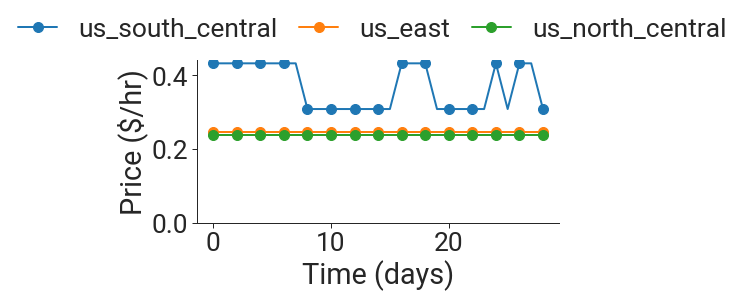

NC12s v2 ('p100', 2)


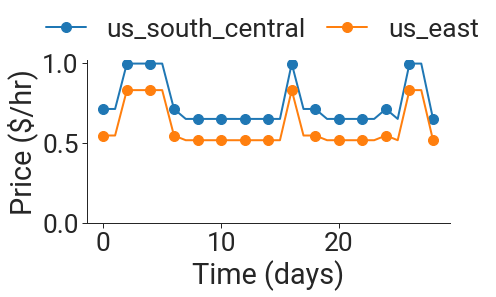

NC12s v3 ('v100', 2)


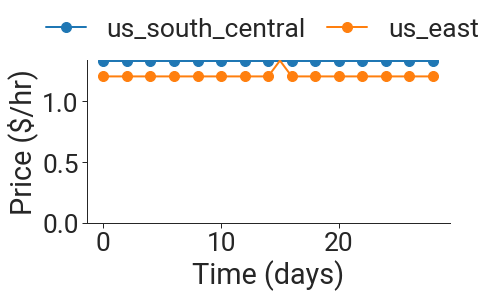

NC24 ('k80', 4)


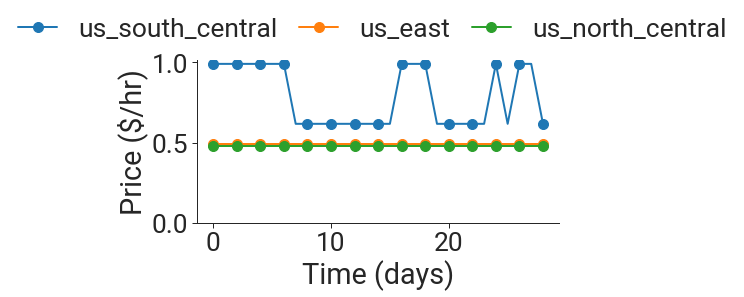

NC24r ('k80', 4)


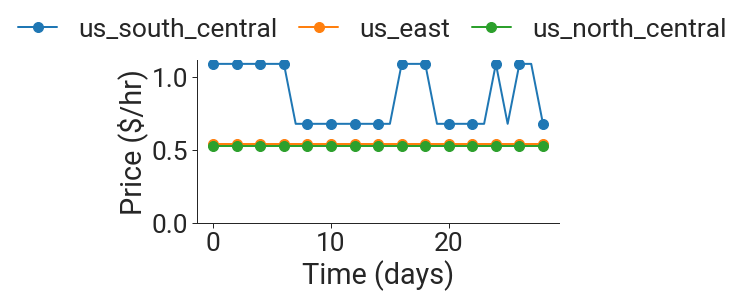

NC24rs v2 ('p100', 4)


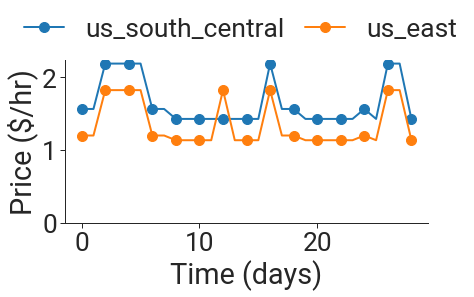

NC24rs v3 ('v100', 4)


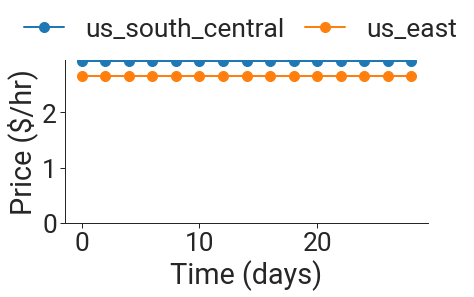

NC24s v2 ('p100', 4)


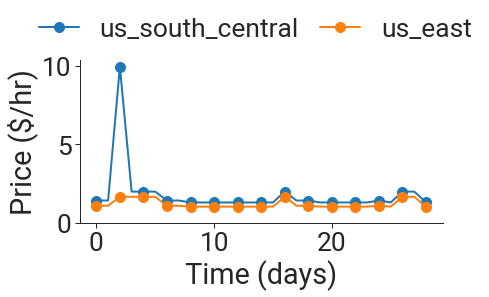

NC24s v3 ('v100', 4)


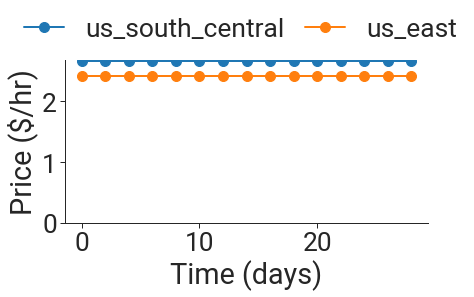

NC6 ('k80', 1)


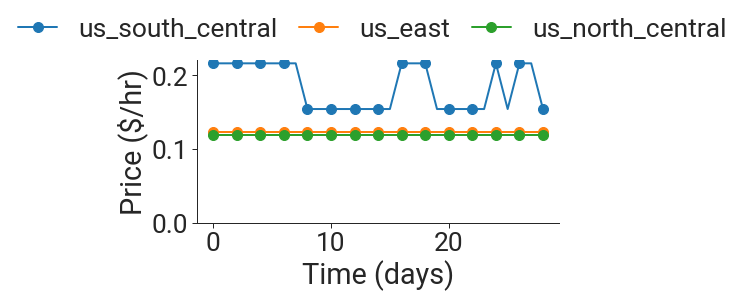

NC6s v2 ('p100', 1)


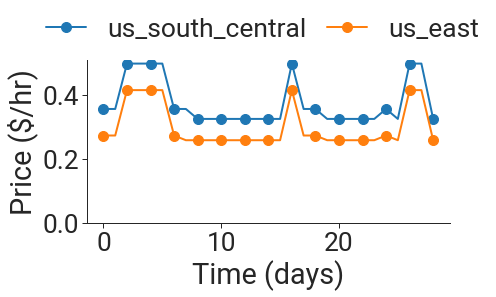

NC6s v3 ('v100', 1)


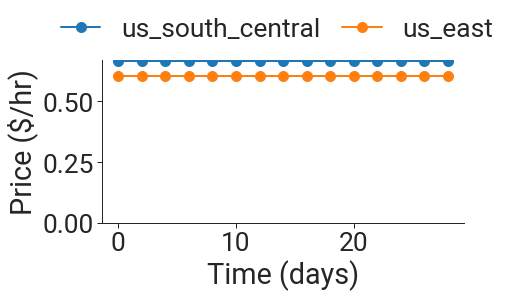

In [4]:
plot_prices(utils.read_azure_prices("../logs/azure/cost"),
            output_directory="../graphs/azure/cost")

# Print cost reduction from on-demand to spot

In [5]:
spot_prices = utils.read_azure_prices("../logs/azure/cost")
on_demand_prices = {'NC6s v3': 3.06, 'NC6s v2': 2.07,
                    'NC6': 0.90}
region = 'us_east'
for instance_type in on_demand_prices:
    spot_prices_for_instance_type = spot_prices[instance_type]
    best_spot_price = None
    for x in spot_prices_for_instance_type:
        if x[0] == region:
            spot_price = float(x[2].replace("$", ""))
            if best_spot_price is None or best_spot_price > spot_price:
                best_spot_price = spot_price
    print(instance_type, "%.2f" % (on_demand_prices[instance_type] / spot_price))

NC6s v3 5.07
NC6s v2 8.03
NC6 7.33
